In [1]:
import numpy as np
import cv2
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics
from utils.utils import fix_colors

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/tomek/.local/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/home/tomek/.local/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='c

# Data preparing

Napisaliśmy funkcję, która dla zbioru obrazów 256 x 256 wycina losową ilość kwadratów o wymiarach 3 x 3 oraz 32 x 32.
Dla każdego 

# OpenCV inpainting

In [2]:
def classic_inpaint(img, mask, radius=3):
    return cv2.inpaint(img, mask, inpaintRadius=radius, flags=cv2.INPAINT_TELEA) / 255

# Neural Network inpainting

### Dataset

In [3]:
train_dataset = ImageSet("data/inpainting/train", "data/intermediate/train", transform, impainting=True)
valid_dataset = ImageSet("data/inpainting/valid", "data/intermediate/valid", transform, impainting=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Model

In [4]:
class InpaintingCNN(nn.Module):
    def __init__(self):
        super(InpaintingCNN, self).__init__()

        # **Encoder** (Ekstrakcja cech)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.ReLU()
        )

        # **Decoder** (Rekonstrukcja obrazu)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 128 -> 256
            nn.Sigmoid()  # Sigmoid, bo chcemy wartości w zakresie 0-1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# model = InpaintingCNN()
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

In [7]:
# import tqdm

# num_epochs = 10
# losses = {"train":[],"val":[]}


# for epoch in range(num_epochs):
#     model.train()
#     for x, y in tqdm.tqdm(train_dataloader):
#         optimizer.zero_grad()
#         x, y = x.to(device), y.to(device)

#         out = model(x)
        
#         loss = criterion(out, y)

#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     print(f"epoch #{epoch+1}, loss: {loss}")
#     losses["train"].append(loss)
#     with torch.no_grad():
#         total_loss = 0.0
#         for x, y in valid_dataset:
#             x, y = x.to(device), y.to(device)

#             out = model(x)

#             loss = criterion(out, y)


#             total_loss += loss.item()
#         print("Validation loss:",total_loss)
#     losses["val"].append(total_loss)

In [8]:
# x = range(num_epochs)
# y = losses['val']

# plt.plot(x, y)
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("loss on valid")
# plt.show()

In [9]:
# torch.save(model, "model_inpainting.pth")

### Results

In [ ]:
model = torch.load("model_inpainting.pth", weights_only=False)
# model.to(device)# 

In [11]:
def replace_black_squares(original: np.ndarray, inpainting: np.ndarray):
    black_mask = np.all(original == [0, 0, 0], axis=-1)

    result = original.copy()
    result[black_mask] = inpainting[black_mask]

    return result

In [12]:
for i in range(5):
    a = random.choice(valid_dataset)
    # a = valid_dataset[0]

    model.eval()

    dest = a[1].permute(1, 2, 0).detach().numpy()
    input = a[0].permute(1, 2, 0).detach().numpy()

    black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255
    image_uint8 = (input * 255).astype(np.uint8)
    out_opencv = cv2.inpaint(image_uint8, black_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    # dest = denormalize(dest)

    out = model(a[0].to(device))
    out = out.permute(1, 2, 0).detach().cpu().numpy()
    out = replace_black_squares(input, out)

    fig, axes = plt.subplots(1, 4, figsize=(10, 5)) 

    axes[0].imshow(fix_colors(input))
    axes[0].axis('off')
    axes[0].set_title("Input")

    axes[1].imshow(fix_colors(dest))
    axes[1].axis('off')
    axes[1].set_title("GroundTruth")

    axes[2].imshow(fix_colors(out_opencv))
    axes[2].axis('off')
    axes[2].set_title("Opencv")

    axes[3].imshow(fix_colors(out))
    axes[3].axis('off')
    axes[3].set_title("Model")

NameError: name 'model' is not defined

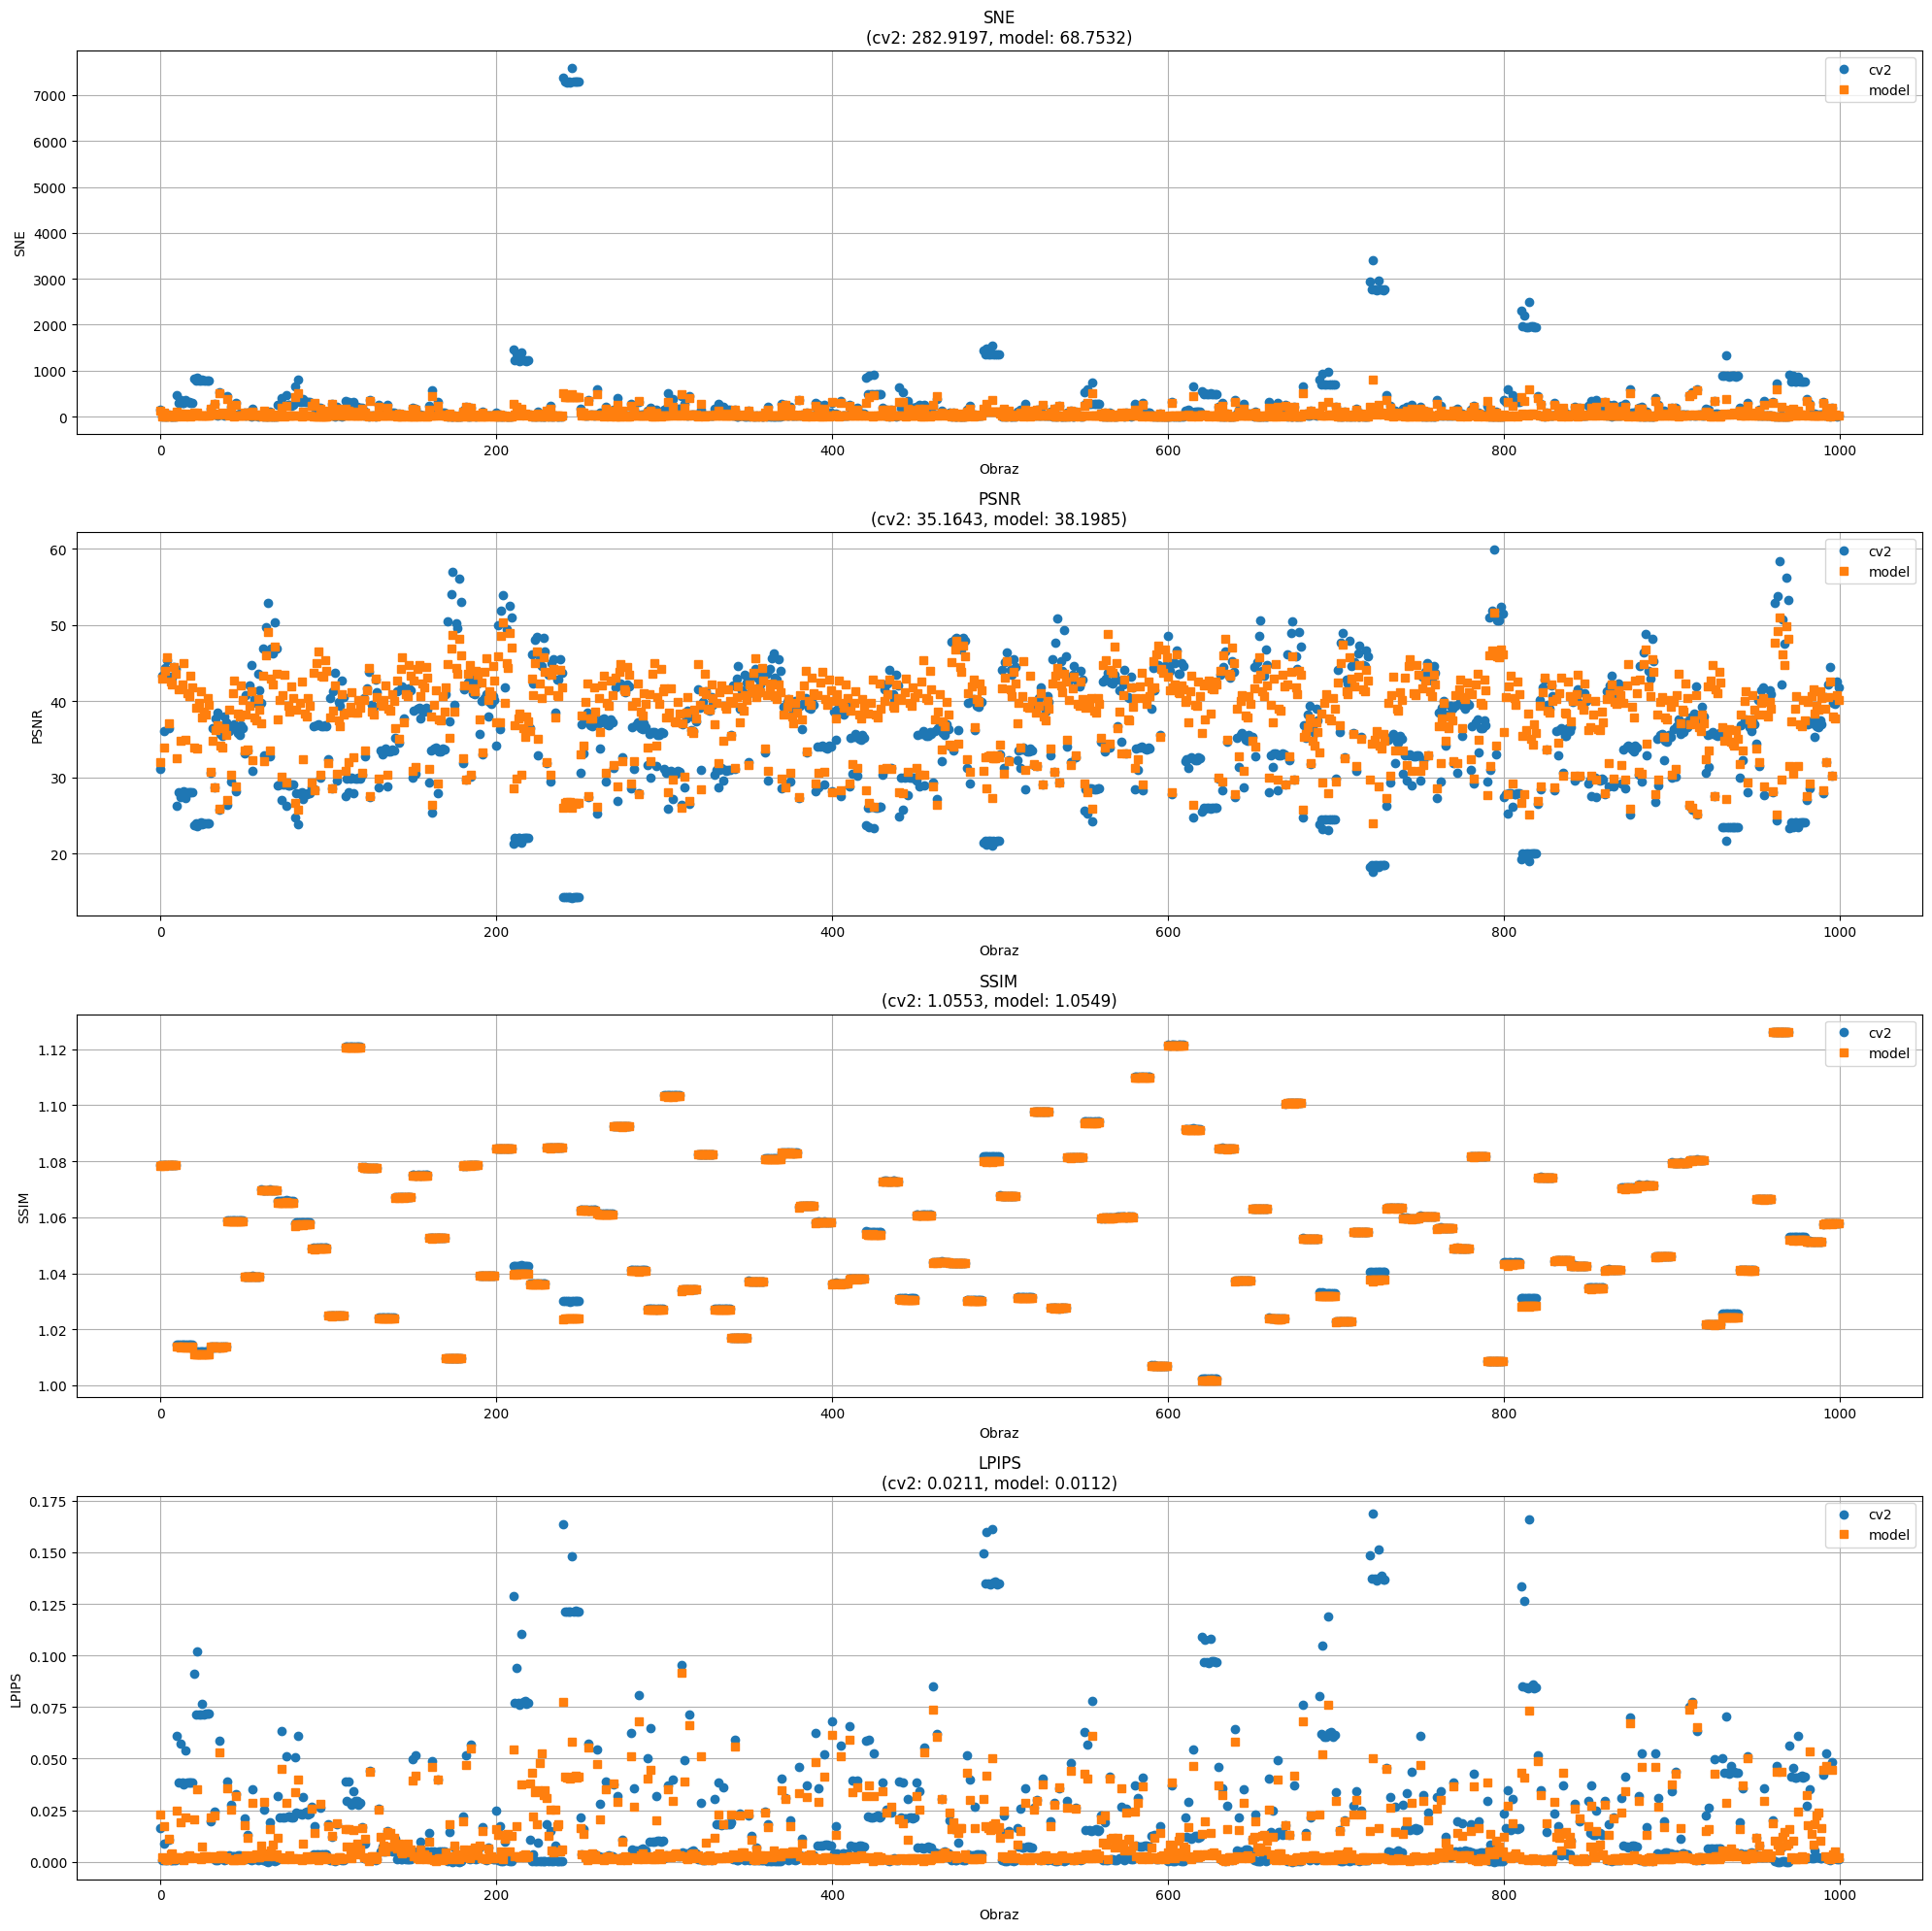

In [ ]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    input = x.permute(1, 2, 0).detach().numpy()

    black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255

    cv2_list.append(classic_inpaint((input * 255).astype(np.uint8), black_mask))

    model_list.append(replace_black_squares(input, model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy()))

plot_metrics(ground_truth_list, cv2_list, model_list)